In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

# For pretty plots
sns.set(style="whitegrid")


In [4]:
# Load real A/B test data
df = pd.read_csv('../data/ab_data.csv')

# Preview the data
df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
# Check for missing values and data types
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
# Group-wise conversion summary
group_summary = df.groupby('group')['converted'].agg(['count', 'sum', 'mean']).reset_index()
group_summary.columns = ['Group', 'Total Users', 'Conversions', 'Conversion Rate']
group_summary


,Group,Total Users,Conversions,Conversion Rate
0,control,147202,17723,0.120399
1,treatment,147276,17514,0.118920


In [7]:
# Extract values needed for Bayesian update
A_success = df.query("group == 'control'")['converted'].sum()
A_total   = df.query("group == 'control'").shape[0]

B_success = df.query("group == 'treatment'")['converted'].sum()
B_total   = df.query("group == 'treatment'").shape[0]

print(f"Control Group: {A_success}/{A_total}")
print(f"Treatment Group: {B_success}/{B_total}")


Control Group: 17723/147202
Treatment Group: 17514/147276


In [8]:
# Define prior parameters
alpha_prior = 1
beta_prior = 1

# Posteriors for each group
posterior_A = beta(alpha_prior + A_success, beta_prior + A_total - A_success)
posterior_B = beta(alpha_prior + B_success, beta_prior + B_total - B_success)


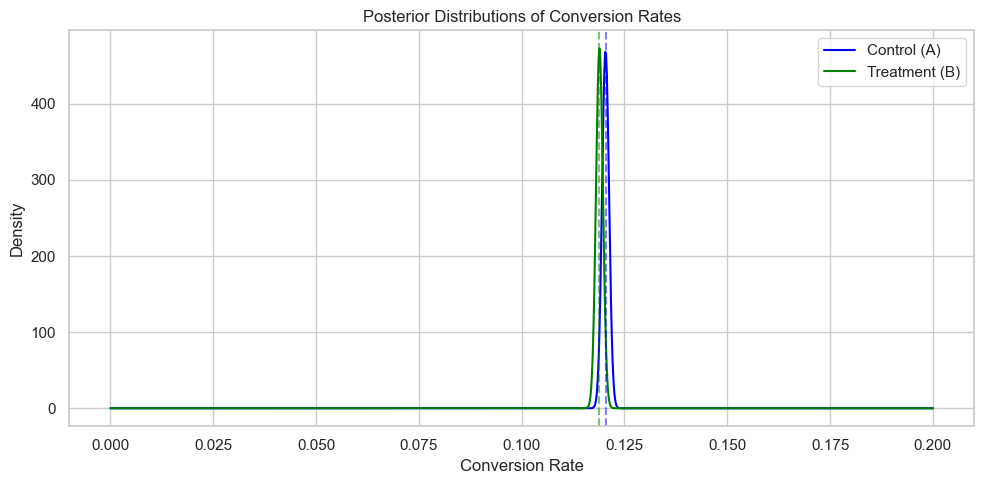

In [9]:
# Range of x (conversion rates)
x = np.linspace(0, 0.2, 1000)

plt.figure(figsize=(10, 5))
plt.plot(x, posterior_A.pdf(x), label="Control (A)", color="blue")
plt.plot(x, posterior_B.pdf(x), label="Treatment (B)", color="green")
plt.axvline(posterior_A.mean(), color='blue', linestyle='--', alpha=0.5)
plt.axvline(posterior_B.mean(), color='green', linestyle='--', alpha=0.5)
plt.title("Posterior Distributions of Conversion Rates")
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/posterior_plot.png')
plt.show()


In [10]:
# Draw samples from both posteriors
samples = 100_000
samples_A = posterior_A.rvs(samples)
samples_B = posterior_B.rvs(samples)

# Probability that B is better than A
prob_B_better = (samples_B > samples_A).mean()
print(f"Probability that Treatment (B) > Control (A): {prob_B_better:.4f}")


Probability that Treatment (B) > Control (A): 0.1075


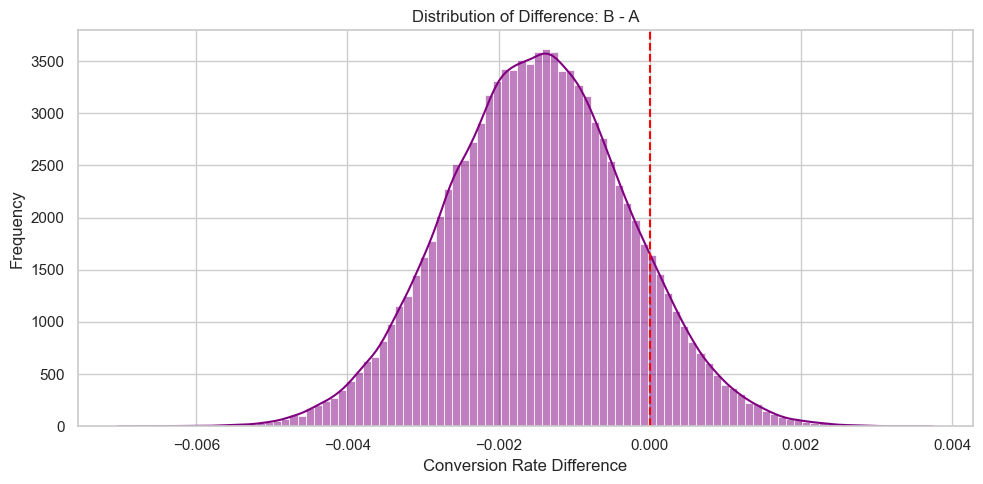

In [11]:
diff = samples_B - samples_A

plt.figure(figsize=(10, 5))
sns.histplot(diff, kde=True, bins=100, color="purple")
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Difference: B - A")
plt.xlabel("Conversion Rate Difference")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [12]:
# Save sampled data (optional, for deeper analysis or plotting)
simulation_df = pd.DataFrame({
    'samples_A': samples_A,
    'samples_B': samples_B,
    'difference': diff
})

simulation_df.to_csv('../outputs/simulation_results.csv', index=False)


In [13]:
print("🔍 Bayesian A/B Test Summary")
print(f"- Control (A) Conversion Rate (posterior mean): {samples_A.mean():.4f}")
print(f"- Treatment (B) Conversion Rate (posterior mean): {samples_B.mean():.4f}")
print(f"- Probability B > A: {prob_B_better:.2%}")

if prob_B_better > 0.95:
    print("✅ High confidence that B is better than A.")
elif prob_B_better < 0.05:
    print("❌ High confidence that A is better than B.")
else:
    print("⚠️ Uncertain — not enough evidence to declare a winner.")


🔍 Bayesian A/B Test Summary
- Control (A) Conversion Rate (posterior mean): 0.1204
- Treatment (B) Conversion Rate (posterior mean): 0.1189
- Probability B > A: 10.75%
⚠️ Uncertain — not enough evidence to declare a winner.
